In [1]:
# !pip install mlrose-hiive
# !pip install chess

In [2]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string
import math

from ast import literal_eval
import chess

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner, NNGSRunner

## Optimization Problem: Travelling Salesperson

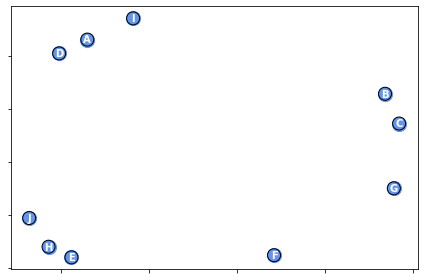

In [3]:
# Generate a new TSP problem using a fixed seed.
problem = TSPGenerator().generate(seed=123456, number_of_cities=10)

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=200, c='cornflowerblue')             # plot A
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='cornflowerblue'))

plt.tight_layout()
plt.show()

### Algorithm 1: Randomized Hill Climbing

In [4]:
rhc = RHCRunner(problem=problem,
                    experiment_name='TSP_rhc',
                    output_directory=None,
                    seed=123,
                    iteration_list=2 ** np.arange(11),
                    max_attempts=500,
                    restart_list=[5, 10, 20])   
# the two data frames will contain the results
df_run_stats, df_run_curves = rhc.run() 

In [5]:
df_run_stats.iloc[:60]

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
0,0,1759.642129,0,0.000260,"[4, 0, 7, 5, 8, 3, 1, 6, 9, 2]",5,1024,0
1,1,1759.642129,1,0.003685,"[4, 0, 7, 5, 8, 3, 1, 6, 9, 2]",5,1024,0
2,2,1671.604860,3,0.005891,"[4, 7, 0, 5, 8, 3, 1, 6, 9, 2]",5,1024,0
3,4,1439.711261,6,0.008580,"[4, 7, 0, 5, 8, 3, 9, 6, 1, 2]",5,1024,0
4,8,1439.711261,10,0.011184,"[4, 7, 0, 5, 8, 3, 9, 6, 1, 2]",5,1024,0
5,16,1230.976954,21,0.013975,"[4, 7, 3, 9, 0, 8, 5, 6, 1, 2]",5,1024,0
6,32,929.753321,40,0.018670,"[9, 7, 4, 3, 0, 8, 2, 6, 1, 5]",5,1024,0
7,64,712.469288,75,0.026086,"[4, 7, 9, 3, 0, 8, 1, 2, 6, 5]",5,1024,0
8,128,712.469288,139,0.041435,"[4, 7, 9, 3, 0, 8, 1, 2, 6, 5]",5,1024,0
9,256,712.469288,267,0.080598,"[4, 7, 9, 3, 0, 8, 1, 2, 6, 5]",5,1024,0


In [6]:
df_run_curves.iloc[:60]

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.000260,1759.642129,0.0,5,1024,0
1,1,0.003685,1759.642129,1.0,5,1024,0
2,2,0.005891,1671.604860,3.0,5,1024,0
3,3,0.008425,1671.604860,4.0,5,1024,0
4,4,0.008580,1439.711261,6.0,5,1024,0
5,5,0.010831,1439.711261,7.0,5,1024,0
6,6,0.010957,1439.711261,8.0,5,1024,0
7,7,0.011075,1439.711261,9.0,5,1024,0
8,8,0.011184,1439.711261,10.0,5,1024,0
9,9,0.013085,1295.718130,12.0,5,1024,0


In [7]:
best_fitness = df_run_curves['Fitness'].min()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]
best_runs

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
1859,78,0.030810,712.469288,1905.0,5,1024,3
1860,79,0.031002,712.469288,1906.0,5,1024,3
1861,80,0.031176,712.469288,1907.0,5,1024,3
1862,81,0.031345,712.469288,1908.0,5,1024,3
1863,82,0.031511,712.469288,1909.0,5,1024,3
...,...,...,...,...,...,...,...
19019,618,0.269970,712.469288,8810.0,20,1024,13
19020,619,0.270478,712.469288,8811.0,20,1024,13
19021,620,0.270987,712.469288,8812.0,20,1024,13
19022,621,0.271495,712.469288,8813.0,20,1024,13


In [8]:
minimum_evaluations = best_runs['FEvals'].min()
best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]
best_curve_run

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
1859,78,0.03081,712.469288,1905.0,5,1024,3
5549,78,0.03081,712.469288,1905.0,10,1024,3
12210,78,0.03081,712.469288,1905.0,20,1024,3


In [9]:
best_Restarts = best_curve_run['Restarts'].iloc()[0]

print(f'Best Restarts: {best_Restarts}')

Best Restarts: 5


In [10]:
run_stats_best_run = df_run_stats[df_run_stats['Restarts'] == best_Restarts]
run_stats_best_run

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
0,0,1759.642129,0,0.000260,"[4, 0, 7, 5, 8, 3, 1, 6, 9, 2]",5,1024,0
1,1,1759.642129,1,0.003685,"[4, 0, 7, 5, 8, 3, 1, 6, 9, 2]",5,1024,0
2,2,1671.604860,3,0.005891,"[4, 7, 0, 5, 8, 3, 1, 6, 9, 2]",5,1024,0
3,4,1439.711261,6,0.008580,"[4, 7, 0, 5, 8, 3, 9, 6, 1, 2]",5,1024,0
4,8,1439.711261,10,0.011184,"[4, 7, 0, 5, 8, 3, 9, 6, 1, 2]",5,1024,0
...,...,...,...,...,...,...,...,...
67,64,822.678820,3230,4.099975,"[9, 3, 0, 8, 1, 6, 2, 5, 4, 7]",5,1024,5
68,128,712.469288,3295,4.257812,"[9, 3, 0, 8, 1, 2, 6, 5, 4, 7]",5,1024,5
69,256,712.469288,3423,4.568685,"[9, 3, 0, 8, 1, 2, 6, 5, 4, 7]",5,1024,5
70,512,712.469288,3679,5.226442,"[9, 3, 0, 8, 1, 2, 6, 5, 4, 7]",5,1024,5


In [11]:
best_state = run_stats_best_run.tail(1)
best_state

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
71,1024,712.469288,3755,5.429274,"[9, 3, 0, 8, 1, 2, 6, 5, 4, 7]",5,1024,5


In [12]:
opt_curve=df_run_curves[(df_run_curves['Restarts']==best_state['Restarts'].iloc[0]) & (df_run_curves['current_restart']==best_state['current_restart'].iloc[0])]
opt_curve

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
3102,1,0.003685,1374.967686,3159.0,5,1024,5
3103,2,0.005891,1361.601550,3161.0,5,1024,5
3104,3,0.008425,1180.593270,3163.0,5,1024,5
3105,4,0.008580,1180.593270,3164.0,5,1024,5
3106,5,0.010831,1180.593270,3165.0,5,1024,5
...,...,...,...,...,...,...,...
3685,584,0.250432,712.469288,3751.0,5,1024,5
3686,585,0.250931,712.469288,3752.0,5,1024,5
3687,586,0.251430,712.469288,3753.0,5,1024,5
3688,587,0.251928,712.469288,3754.0,5,1024,5


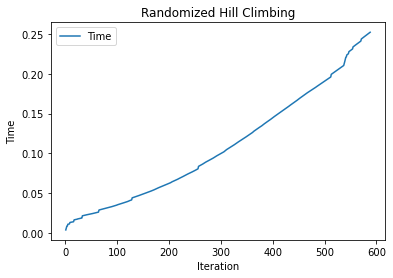

In [13]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('Randomized Hill Climbing')
plt.show()

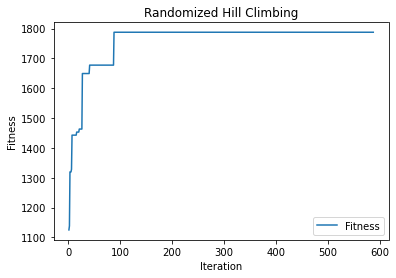

In [14]:
plt.plot(opt_curve['Iteration'],2500-opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.title('Randomized Hill Climbing')
plt.show()

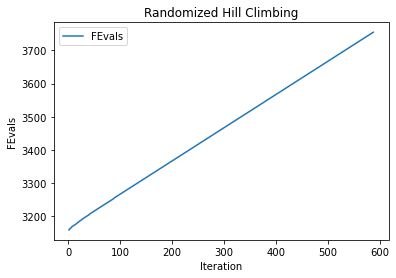

In [15]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('Randomized Hill Climbing')
plt.show()

In [16]:
result1=best_state[['Fitness','FEvals','Time','State']]
result1['Algorithm']='Randomized Hill Climbing'

In [17]:
ordered_state = literal_eval(run_stats_best_run['State'].tail(1).values[0])
edge_labels = {(ordered_state[i], ordered_state[(i+1) % len(ordered_state)]):f'{str(i+1)}➜' for i in range(len(ordered_state))}
# print(ordered_state)

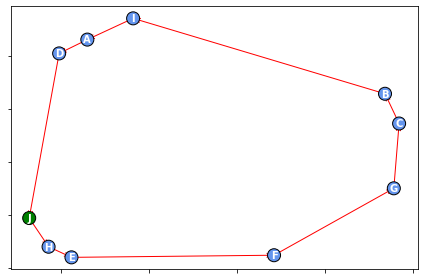

In [18]:

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=1,c='green' if i == 5 else 'cornflowerblue')             # plot A


for i in range(len(ordered_state)):
    start_node = ordered_state[i]
    end_node = ordered_state[(i+1) % len(ordered_state)]
    start_pos = problem.coords[start_node]
    end_pos = problem.coords[end_node]
    ax.annotate("",
            xy=start_pos, xycoords='data',
            xytext=end_pos, textcoords='data',
            c='red',
            arrowprops=dict(arrowstyle="->",
                            ec='red',
                            connectionstyle="arc3"))
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}

for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='green' if i == ordered_state[0] else 'cornflowerblue'))

plt.tight_layout()
plt.show()

### Algorithm 2: Simulated Annealing

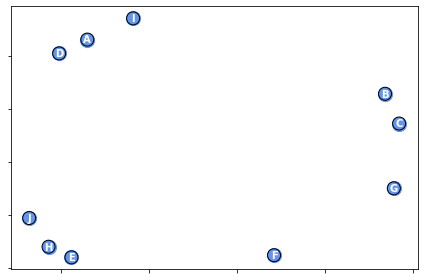

In [19]:
# Generate a new TSP problem using a fixed seed.
problem = TSPGenerator().generate(seed=123456, number_of_cities=10)

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=200, c='cornflowerblue')             # plot A
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='cornflowerblue'))

plt.tight_layout()
plt.show()

In [20]:
# create a runner class and solve the problem
sa = SARunner(problem=problem,
              experiment_name='TSP_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              temperature_list=[0.1, 0.5, 1.0, 2.0, 5.0],
              decay_list=[mlrose_hiive.GeomDecay])

# the two data frames will contain the results
df_run_stats, df_run_curves = sa.run()

In [21]:
df_run_stats.iloc[:60]

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
0,0,1567.561669,0,0.000175,"[8, 7, 6, 4, 5, 3, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.100000,0.1,1024
1,1,1503.723148,2,0.002232,"[8, 3, 6, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099998,0.1,1024
2,2,1503.723148,3,0.004360,"[8, 3, 6, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099996,0.1,1024
3,4,1466.712630,6,0.006623,"[6, 3, 8, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099993,0.1,1024
4,8,1466.712630,10,0.008764,"[6, 3, 8, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099991,0.1,1024
5,16,1357.669489,20,0.011253,"[9, 3, 8, 4, 7, 5, 0, 6, 2, 1]",geometric,0.1,0.99,0.001,0.099989,0.1,1024
6,32,1096.730013,38,0.014626,"[8, 3, 9, 4, 7, 5, 6, 0, 2, 1]",geometric,0.1,0.99,0.001,0.099985,0.1,1024
7,64,1016.691015,74,0.020106,"[3, 1, 9, 7, 4, 5, 6, 2, 0, 8]",geometric,0.1,0.99,0.001,0.099980,0.1,1024
8,128,748.361257,141,0.032168,"[3, 0, 9, 7, 4, 5, 6, 2, 1, 8]",geometric,0.1,0.99,0.001,0.099968,0.1,1024
9,256,712.469288,270,0.063245,"[0, 3, 9, 7, 4, 5, 6, 2, 1, 8]",geometric,0.1,0.99,0.001,0.099936,0.1,1024


In [22]:
df_run_curves

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
0,0,0.000175,1567.561669,0.0,0.1,1024
1,1,0.002232,1503.723148,2.0,0.1,1024
2,2,0.004360,1503.723148,3.0,0.1,1024
3,3,0.006514,1466.712630,5.0,0.1,1024
4,4,0.006623,1466.712630,6.0,0.1,1024
...,...,...,...,...,...,...
3585,713,0.325995,712.469288,727.0,5.0,1024
3586,714,0.326583,712.469288,728.0,5.0,1024
3587,715,0.327170,712.469288,729.0,5.0,1024
3588,716,0.327756,712.469288,730.0,5.0,1024


In [23]:
best_fitness = df_run_curves['Fitness'].min()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]
best_runs

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
217,217,0.053196,712.469288,231.0,0.1,1024
218,218,0.053441,712.469288,232.0,0.1,1024
219,219,0.053686,712.469288,233.0,0.1,1024
220,220,0.053929,712.469288,234.0,0.1,1024
221,221,0.054172,712.469288,235.0,0.1,1024
...,...,...,...,...,...,...
3585,713,0.325995,712.469288,727.0,5.0,1024
3586,714,0.326583,712.469288,728.0,5.0,1024
3587,715,0.327170,712.469288,729.0,5.0,1024
3588,716,0.327756,712.469288,730.0,5.0,1024


In [24]:
minimum_evaluations = best_runs['FEvals'].min()
best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]
best_curve_run

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
217,217,0.053196,712.469288,231.0,0.1,1024
935,217,0.053196,712.469288,231.0,0.5,1024
1653,217,0.053196,712.469288,231.0,1.0,1024
2371,217,0.053196,712.469288,231.0,2.0,1024
3089,217,0.053196,712.469288,231.0,5.0,1024


In [25]:
best_init_temperature = best_curve_run['Temperature'].iloc()[0].init_temp

print(f'Best initial temperature: {best_init_temperature}')

Best initial temperature: 0.1


In [26]:
run_stats_best_run = df_run_stats[df_run_stats['schedule_init_temp'] == best_init_temperature]
run_stats_best_run

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
0,0,1567.561669,0,0.000175,"[8, 7, 6, 4, 5, 3, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.100000,0.1,1024
1,1,1503.723148,2,0.002232,"[8, 3, 6, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099998,0.1,1024
2,2,1503.723148,3,0.004360,"[8, 3, 6, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099996,0.1,1024
3,4,1466.712630,6,0.006623,"[6, 3, 8, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099993,0.1,1024
4,8,1466.712630,10,0.008764,"[6, 3, 8, 4, 5, 7, 0, 9, 2, 1]",geometric,0.1,0.99,0.001,0.099991,0.1,1024
5,16,1357.669489,20,0.011253,"[9, 3, 8, 4, 7, 5, 0, 6, 2, 1]",geometric,0.1,0.99,0.001,0.099989,0.1,1024
6,32,1096.730013,38,0.014626,"[8, 3, 9, 4, 7, 5, 6, 0, 2, 1]",geometric,0.1,0.99,0.001,0.099985,0.1,1024
7,64,1016.691015,74,0.020106,"[3, 1, 9, 7, 4, 5, 6, 2, 0, 8]",geometric,0.1,0.99,0.001,0.099980,0.1,1024
8,128,748.361257,141,0.032168,"[3, 0, 9, 7, 4, 5, 6, 2, 1, 8]",geometric,0.1,0.99,0.001,0.099968,0.1,1024
9,256,712.469288,270,0.063245,"[0, 3, 9, 7, 4, 5, 6, 2, 1, 8]",geometric,0.1,0.99,0.001,0.099936,0.1,1024


In [27]:
best_state = run_stats_best_run.tail(1)
best_state

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
11,1024,712.469288,731,0.328342,"[0, 3, 9, 7, 4, 5, 6, 2, 1, 8]",geometric,0.1,0.99,0.001,0.099671,0.1,1024


In [28]:
opt_curve=df_run_curves[(df_run_curves['Temperature']==best_state['Temperature'].iloc[0])]
opt_curve

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
0,0,0.000175,1567.561669,0.0,0.1,1024
1,1,0.002232,1503.723148,2.0,0.1,1024
2,2,0.004360,1503.723148,3.0,0.1,1024
3,3,0.006514,1466.712630,5.0,0.1,1024
4,4,0.006623,1466.712630,6.0,0.1,1024
...,...,...,...,...,...,...
713,713,0.325995,712.469288,727.0,0.1,1024
714,714,0.326583,712.469288,728.0,0.1,1024
715,715,0.327170,712.469288,729.0,0.1,1024
716,716,0.327756,712.469288,730.0,0.1,1024


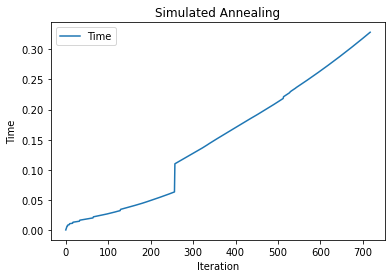

In [29]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('Simulated Annealing')
plt.show()

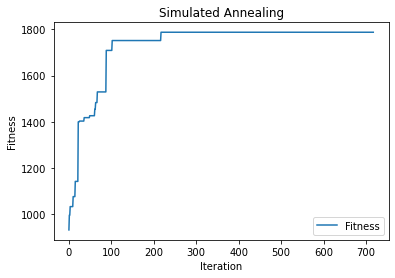

In [30]:
plt.plot(opt_curve['Iteration'],2500-opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.title('Simulated Annealing')
plt.show()

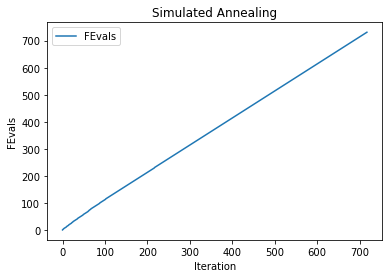

In [31]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('Simulated Annealing')
plt.show()

In [32]:
result2=best_state[['Fitness','FEvals','Time','State']]
result2['Algorithm']='Simulated Annealing'

In [33]:
ordered_state = literal_eval(run_stats_best_run['State'].tail(1).values[0])
edge_labels = {(ordered_state[i], ordered_state[(i+1) % len(ordered_state)]):f'{str(i+1)}➜' for i in range(len(ordered_state))}
# print(ordered_state)

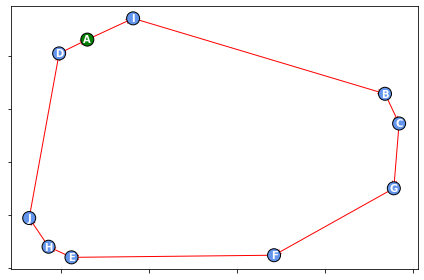

In [34]:

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=1,c='green' if i == 5 else 'cornflowerblue')             # plot A


for i in range(len(ordered_state)):
    start_node = ordered_state[i]
    end_node = ordered_state[(i+1) % len(ordered_state)]
    start_pos = problem.coords[start_node]
    end_pos = problem.coords[end_node]
    ax.annotate("",
            xy=start_pos, xycoords='data',
            xytext=end_pos, textcoords='data',
            c='red',
            arrowprops=dict(arrowstyle="->",
                            ec='red',
                            connectionstyle="arc3"))
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}

for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='green' if i == ordered_state[0] else 'cornflowerblue'))

plt.tight_layout()
plt.show()

### Algorithm 3: Generic Algorithm

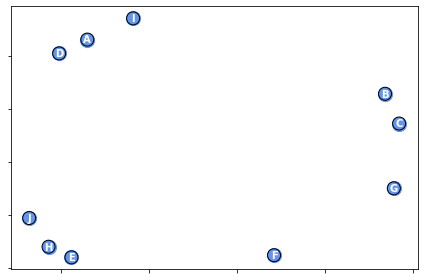

In [70]:
# Generate a new TSP problem using a fixed seed.
problem = TSPGenerator().generate(seed=123456, number_of_cities=10)

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=200, c='cornflowerblue')             # plot A
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='cornflowerblue'))

plt.tight_layout()
plt.show()

In [71]:
ga = GARunner(problem=problem,
                  experiment_name='TSP_ga',
                  output_directory=None,
                  seed=1234,
                  iteration_list=2 ** np.arange(11),
                  max_attempts=500,
                  population_sizes=[10, 20, 50, 100, 150],
                  mutation_rates=[0.1, 0.3, 0.5, 0.7])
                  
# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run() 

In [72]:
df_run_stats.iloc[:60]

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
0,0,1747.246892,10,0.001013,"[7, 2, 9, 1, 0, 8, 4, 5, 6, 3]",10,0.1,1024
1,1,1240.798636,22,0.005185,"[4, 9, 5, 2, 6, 8, 3, 1, 0, 7]",10,0.1,1024
2,2,1108.349293,34,0.009387,"[4, 9, 5, 2, 0, 8, 3, 1, 6, 7]",10,0.1,1024
3,4,1108.349293,56,0.014812,"[4, 9, 5, 2, 0, 8, 3, 1, 6, 7]",10,0.1,1024
4,8,1084.032199,103,0.023722,"[4, 7, 9, 5, 2, 0, 8, 3, 1, 6]",10,0.1,1024
5,16,947.224184,194,0.038067,"[4, 7, 9, 5, 2, 1, 6, 8, 3, 0]",10,0.1,1024
6,32,849.023777,372,0.064460,"[9, 7, 4, 5, 2, 1, 6, 8, 0, 3]",10,0.1,1024
7,64,842.607846,725,0.107643,"[9, 7, 4, 5, 1, 2, 6, 8, 0, 3]",10,0.1,1024
8,128,842.607846,1429,0.182649,"[9, 7, 4, 5, 1, 2, 6, 8, 0, 3]",10,0.1,1024
9,256,712.469288,2838,0.335702,"[9, 7, 4, 5, 6, 2, 1, 8, 0, 3]",10,0.1,1024


In [73]:
df_run_curves

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
0,0,0.001013,1747.246892,10.0,10,0.1,1024
1,1,0.005185,1240.798636,22.0,10,0.1,1024
2,2,0.009387,1108.349293,34.0,10,0.1,1024
3,3,0.012983,1108.349293,45.0,10,0.1,1024
4,4,0.014812,1108.349293,56.0,10,0.1,1024
...,...,...,...,...,...,...,...
12135,511,0.691054,712.469288,77314.0,150,0.7,1024
12136,512,0.692426,712.469288,77465.0,150,0.7,1024
12137,513,0.696269,712.469288,77616.0,150,0.7,1024
12138,514,0.697716,712.469288,77767.0,150,0.7,1024


In [74]:
best_fitness = df_run_curves['Fitness'].min()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]
best_runs

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
784,73,0.119378,712.469288,826.0,10,0.3,1024
785,74,0.120523,712.469288,837.0,10,0.3,1024
786,75,0.121624,712.469288,848.0,10,0.3,1024
787,76,0.122728,712.469288,859.0,10,0.3,1024
788,77,0.123830,712.469288,870.0,10,0.3,1024
...,...,...,...,...,...,...,...
12135,511,0.691054,712.469288,77314.0,150,0.7,1024
12136,512,0.692426,712.469288,77465.0,150,0.7,1024
12137,513,0.696269,712.469288,77616.0,150,0.7,1024
12138,514,0.697716,712.469288,77767.0,150,0.7,1024


In [75]:
minimum_evaluations = best_runs['FEvals'].min()
best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]
best_curve_run

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
784,73,0.119378,712.469288,826.0,10,0.3,1024


In [76]:
best_Population_Size = best_curve_run['Population Size'].iloc()[0]
best_Mutation_Rate = best_curve_run['Mutation Rate'].iloc()[0]
print(f'Best Population: {best_Population_Size}')
print(f'Best Mutation Rate: {best_Mutation_Rate}')

Best Population: 10
Best Mutation Rate: 0.3


In [77]:
run_stats_best_run = df_run_stats[(df_run_stats['Population Size'] == best_Population_Size) & (df_run_stats['Mutation Rate'] == best_Mutation_Rate)]
run_stats_best_run

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
12,0,1747.246892,10,0.000576,"[7, 2, 9, 1, 0, 8, 4, 5, 6, 3]",10,0.3,1024
13,1,1240.798636,22,0.003763,"[4, 9, 5, 2, 6, 8, 3, 1, 0, 7]",10,0.3,1024
14,2,1240.798636,33,0.007017,"[4, 9, 5, 2, 6, 8, 3, 1, 0, 7]",10,0.3,1024
15,4,1176.243785,56,0.011604,"[8, 0, 4, 5, 6, 1, 2, 3, 7, 9]",10,0.3,1024
16,8,1116.386277,102,0.018588,"[4, 9, 8, 0, 5, 6, 1, 2, 3, 7]",10,0.3,1024
17,16,1105.934825,191,0.031094,"[4, 8, 0, 5, 6, 1, 2, 3, 9, 7]",10,0.3,1024
18,32,1075.324685,369,0.050714,"[4, 5, 0, 8, 6, 2, 1, 3, 9, 7]",10,0.3,1024
19,64,789.754671,725,0.088387,"[7, 9, 0, 8, 3, 1, 2, 6, 5, 4]",10,0.3,1024
20,128,712.469288,1431,0.164358,"[7, 9, 3, 0, 8, 1, 2, 6, 5, 4]",10,0.3,1024
21,256,712.469288,2839,0.327954,"[7, 9, 3, 0, 8, 1, 2, 6, 5, 4]",10,0.3,1024


In [78]:
best_state = run_stats_best_run.tail(1)
best_state

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
23,1024,712.469288,6326,0.779409,"[7, 9, 3, 0, 8, 1, 2, 6, 5, 4]",10,0.3,1024


In [79]:
opt_curve=df_run_curves[(df_run_curves['Population Size']==best_state['Population Size'].iloc[0]) & (df_run_curves['Mutation Rate']==best_state['Mutation Rate'].iloc[0])]
opt_curve

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
711,0,0.001013,1747.246892,10.0,10,0.3,1024
712,1,0.005185,1240.798636,22.0,10,0.3,1024
713,2,0.009387,1240.798636,33.0,10,0.3,1024
714,3,0.012983,1240.798636,44.0,10,0.3,1024
715,4,0.014812,1176.243785,56.0,10,0.3,1024
...,...,...,...,...,...,...,...
1280,569,0.778543,712.469288,6282.0,10,0.3,1024
1281,570,0.779986,712.469288,6293.0,10,0.3,1024
1282,571,0.781465,712.469288,6304.0,10,0.3,1024
1283,572,0.782910,712.469288,6315.0,10,0.3,1024


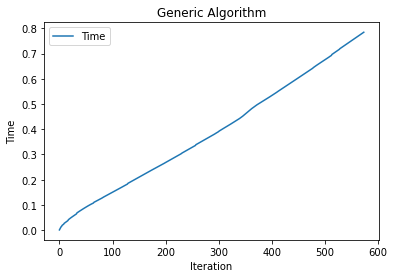

In [80]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('Generic Algorithm')
plt.show()

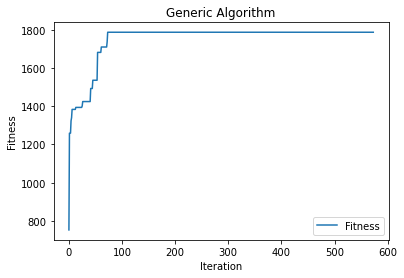

In [81]:
plt.plot(opt_curve['Iteration'],2500-opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.title('Generic Algorithm')
plt.show()

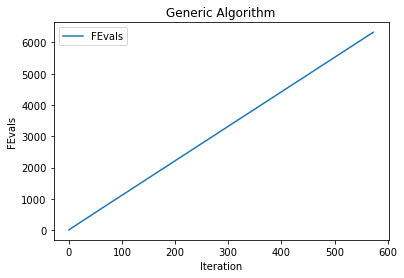

In [82]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('Generic Algorithm')
plt.show()

In [83]:
result3=best_state[['Fitness','FEvals','Time','State']]
result3['Algorithm']='Genetic Algorithm'

In [84]:
ordered_state = literal_eval(run_stats_best_run['State'].tail(1).values[0])
edge_labels = {(ordered_state[i], ordered_state[(i+1) % len(ordered_state)]):f'{str(i+1)}➜' for i in range(len(ordered_state))}
# print(ordered_state)

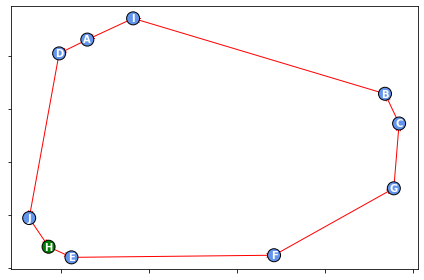

In [85]:

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=1,c='green' if i == 5 else 'cornflowerblue')             # plot A


for i in range(len(ordered_state)):
    start_node = ordered_state[i]
    end_node = ordered_state[(i+1) % len(ordered_state)]
    start_pos = problem.coords[start_node]
    end_pos = problem.coords[end_node]
    ax.annotate("",
            xy=start_pos, xycoords='data',
            xytext=end_pos, textcoords='data',
            c='red',
            arrowprops=dict(arrowstyle="->",
                            ec='red',
                            connectionstyle="arc3"))
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}

for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='green' if i == ordered_state[0] else 'cornflowerblue'))

plt.tight_layout()
plt.show()

### Algorithm 4: MIMIC

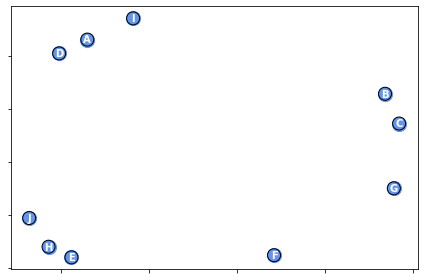

In [51]:
# Generate a new TSP problem using a fixed seed.
problem = TSPGenerator().generate(seed=123456, number_of_cities=10)

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=200, c='cornflowerblue')             # plot A
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='cornflowerblue'))

plt.tight_layout()
plt.show()

In [52]:
mmc = MIMICRunner(problem=problem,
                      experiment_name='TSP_mimic',
                      output_directory=None,
                      seed=12345,
                      iteration_list=2 ** np.arange(11),
                      max_attempts=500,
                      population_sizes=[150, 200],
                      keep_percent_list=[0.25, 0.5, 0.75])
                      
# the two data frames will contain the results
df_run_stats, df_run_curves = mmc.run()

In [53]:
df_run_stats.iloc[:60]

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
0,0,1906.012923,150,0.008310,"[0, 7, 3, 9, 6, 4, 1, 8, 5, 2]",False,150,0.25,1024
1,1,876.549158,302,0.113604,"[2, 5, 4, 9, 7, 3, 0, 8, 1, 6]",False,150,0.25,1024
2,2,776.541018,454,0.281727,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024
3,4,776.541018,756,0.477126,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024
4,8,776.541018,1360,0.891448,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024
5,16,776.541018,2568,1.772508,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024
6,32,776.541018,4984,3.466560,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024
7,64,776.541018,9816,6.572624,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024
8,128,776.541018,19480,12.923125,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024
9,256,776.541018,38808,25.841367,"[5, 7, 4, 9, 0, 3, 8, 1, 2, 6]",False,150,0.25,1024


In [54]:
df_run_curves

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,Keep Percent,max_iters
0,0,0.008310,1906.012923,150.0,False,150,0.25,1024
1,1,0.113604,876.549158,302.0,False,150,0.25,1024
2,2,0.281727,776.541018,454.0,False,150,0.25,1024
3,3,0.381457,776.541018,605.0,False,150,0.25,1024
4,4,0.477126,776.541018,756.0,False,150,0.25,1024
...,...,...,...,...,...,...,...,...
3039,505,0.225686,790.318741,101709.0,False,200,0.75,1024
3040,506,0.332465,790.318741,101910.0,False,200,0.75,1024
3041,507,0.435976,790.318741,102111.0,False,200,0.75,1024
3042,508,0.543303,790.318741,102312.0,False,200,0.75,1024


In [55]:
best_fitness = df_run_curves['Fitness'].min()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]
best_runs

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,Keep Percent,max_iters
2033,3,0.381457,748.361257,806.0,False,200,0.5,1024
2034,4,0.477126,748.361257,1007.0,False,200,0.5,1024
2035,5,0.572190,748.361257,1208.0,False,200,0.5,1024
2036,6,0.670416,748.361257,1409.0,False,200,0.5,1024
2037,7,0.778035,748.361257,1610.0,False,200,0.5,1024
...,...,...,...,...,...,...,...,...
2529,499,50.202375,748.361257,100502.0,False,200,0.5,1024
2530,500,50.326086,748.361257,100703.0,False,200,0.5,1024
2531,501,50.426389,748.361257,100904.0,False,200,0.5,1024
2532,502,50.522904,748.361257,101105.0,False,200,0.5,1024


In [56]:
minimum_evaluations = best_runs['FEvals'].min()
best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]
best_curve_run

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,Keep Percent,max_iters
2033,3,0.381457,748.361257,806.0,False,200,0.5,1024


In [57]:
best_Keep_Percent = best_curve_run['Keep Percent'].iloc()[0]
best_Population_Size = best_curve_run['Population Size'].iloc()[0]
print(f'Best Percent: {best_Keep_Percent}')
print(f'Best Population Size: {best_Population_Size}')

Best Percent: 0.5
Best Population Size: 200


In [58]:
run_stats_best_run = df_run_stats[(df_run_stats['Keep Percent'] == best_Keep_Percent) & (df_run_stats['Population Size']==best_Population_Size)]
run_stats_best_run

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
48,0,1906.012923,200,0.009367,"[0, 7, 3, 9, 6, 4, 1, 8, 5, 2]",False,200,0.5,1024
49,1,877.203538,402,0.155441,"[6, 8, 0, 3, 9, 4, 7, 5, 2, 1]",False,200,0.5,1024
50,2,825.511990,604,0.291644,"[6, 5, 7, 4, 9, 0, 3, 8, 2, 1]",False,200,0.5,1024
51,4,748.361257,1007,0.544732,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024
52,8,748.361257,1811,1.026237,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024
53,16,748.361257,3419,1.953779,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024
54,32,748.361257,6635,3.819033,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024
55,64,748.361257,13067,8.053499,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024
56,128,748.361257,25931,15.969766,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024
57,256,748.361257,51659,32.080885,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024


In [59]:
best_state = run_stats_best_run.tail(1)
best_state

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
59,1024,748.361257,101306,61.51314,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",False,200,0.5,1024


In [60]:
opt_curve=df_run_curves[(df_run_curves['Keep Percent']==best_state['Keep Percent'].iloc[0]) & (df_run_curves['Population Size']==best_state['Population Size'].iloc[0])]
opt_curve

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,Keep Percent,max_iters
2030,0,0.008310,1906.012923,200.0,False,200,0.5,1024
2031,1,0.113604,877.203538,402.0,False,200,0.5,1024
2032,2,0.281727,825.511990,604.0,False,200,0.5,1024
2033,3,0.381457,748.361257,806.0,False,200,0.5,1024
2034,4,0.477126,748.361257,1007.0,False,200,0.5,1024
...,...,...,...,...,...,...,...,...
2529,499,50.202375,748.361257,100502.0,False,200,0.5,1024
2530,500,50.326086,748.361257,100703.0,False,200,0.5,1024
2531,501,50.426389,748.361257,100904.0,False,200,0.5,1024
2532,502,50.522904,748.361257,101105.0,False,200,0.5,1024


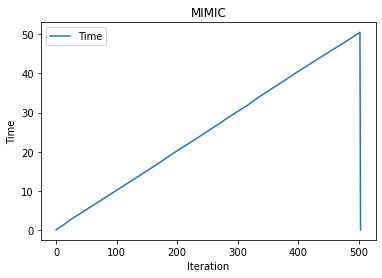

In [61]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('MIMIC')
plt.show()

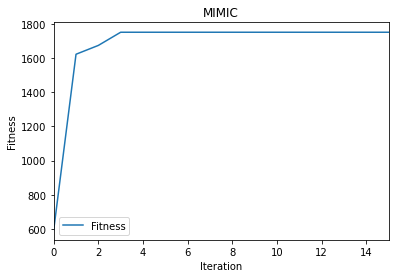

In [62]:
plt.plot(opt_curve['Iteration'],2500-opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.xlim([0,15])
plt.legend()
plt.title('MIMIC')
plt.show()

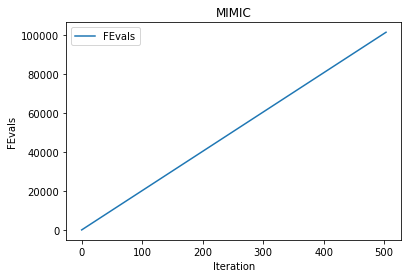

In [63]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('MIMIC')
plt.show()

In [64]:
result4=best_state[['Fitness','FEvals','Time','State']]
result4['Algorithm']='MIMIC'

In [65]:
ordered_state = literal_eval(run_stats_best_run['State'].tail(1).values[0])
edge_labels = {(ordered_state[i], ordered_state[(i+1) % len(ordered_state)]):f'{str(i+1)}➜' for i in range(len(ordered_state))}
# print(ordered_state)

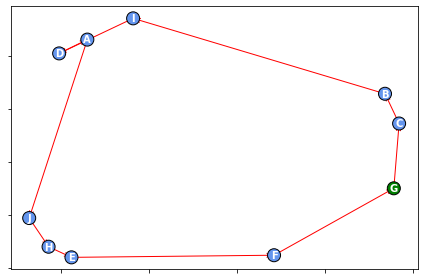

In [66]:

fig, ax = plt.subplots(1)         # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x,y) in enumerate(problem.coords):
    ax.scatter(x,y, s=1,c='green' if i == 5 else 'cornflowerblue')             # plot A


for i in range(len(ordered_state)):
    start_node = ordered_state[i]
    end_node = ordered_state[(i+1) % len(ordered_state)]
    start_pos = problem.coords[start_node]
    end_pos = problem.coords[end_node]
    ax.annotate("",
            xy=start_pos, xycoords='data',
            xytext=end_pos, textcoords='data',
            c='red',
            arrowprops=dict(arrowstyle="->",
                            ec='red',
                            connectionstyle="arc3"))
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}

for i in node_labels.keys():
    x,y = problem.coords[i]
    plt.text(x, y, node_labels[i], ha="center", va="center", c='white', fontweight='bold',
             bbox = dict(boxstyle=f"circle,pad=0.15", fc='green' if i == ordered_state[0] else 'cornflowerblue'))

plt.tight_layout()
plt.show()

### Algorithm Comparison

In [67]:
results=pd.concat([result1,result2,result3,result4])

In [68]:
results['Fitness']=2500-results['Fitness']

In [69]:
results

,Fitness,FEvals,Time,State,Algorithm
71,1787.530712,3755,5.429274,"[9, 3, 0, 8, 1, 2, 6, 5, 4, 7]",Randomized Hill Climbing
11,1787.530712,731,0.328342,"[0, 3, 9, 7, 4, 5, 6, 2, 1, 8]",Simulated Annealing
23,1787.530712,6326,0.771824,"[7, 9, 3, 0, 8, 1, 2, 6, 5, 4]",Genetic Algorithm
59,1751.638743,101306,61.513140,"[6, 5, 4, 7, 9, 0, 3, 8, 1, 2]",MIMIC
